In [87]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from pca import visualize_kmeans
from kneed import KneeLocator
import umap.umap_ as umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [88]:
DISCOVERY = True
USE_UMAP = True
USE_TSNE = True
SAVE_PATH = "../../data/labeled_clusters.csv"

In [89]:
#  Load data 
df = pd.read_csv("../../data/normalized_matches.csv")
print(f"Loaded {len(df)} rows")

#  Clean NaNs and invalid values 
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
print(f"Columns available: {len(df.columns)}")

# Encode champion tags
if "tags" in df.columns:
    print("Encoding champion tags")
    # Split tags like "Fighter,Assassin" into separate flags
    tag_dummies = (
        df["tags"]
        .fillna("")
        .str.get_dummies(sep=",")
        .add_prefix("tag_")
    )
    df = pd.concat([df, tag_dummies], axis=1)
    print(f" Added {len(tag_dummies.columns)} tag columns: {list(tag_dummies.columns)}")
if "role" in df.columns:
    print("Encoding role column numerically")
    df["role"] = (
        df["role"]
        .astype(str)
        .str.upper()
        .replace({"UTILITY": "SUPPORT"})
    )

    # Define a numeric mapping for roles
    role_map = {
        "TOP": 1,
        "JUNGLE": 2,
        "MIDDLE": 3,
        "BOTTOM": 4,
        "SUPPORT": 5
    }

    before_roles = len(df)
    df = df[df["role"].isin(role_map.keys())]
    print(f"Filtered {before_roles - len(df)} rows with invalid roles")

    # Map to integers
    df["role"] = df["role"].map(role_map)
    print(f"Role encoding applied: {role_map}")
#  Filter out players with no perk data 
before = len(df)
df = df[
    ~((df["perk_offense"] == 0) &
      (df["perk_flex"] == 0) &
      (df["perk_defense"] == 0))
]
# perk_offense,flex and defense are the 3 small runes -> tbh we should just use this to prune and these are not really good features but actual rune data will be good
# primarystyle_id -> is the main rune tree (i.e. precision,domination etc) -> might use this over independent runes
# primarystyle_perk1 -> keystone rune (VERY IMPORTANT probably keep)
# primarystyle_perk2 -> second rune in main tree
# primarystyle_perk3 -> third rune in main tree
# substyle_id -> secondary rune tree
# substyle_perk1 -> first rune in secondary tree
# substyle_perk2 -> second rune in secondary tree
print(f"Filtered {before - len(df)} rows with all-zero perks, remaining: {len(df)}")


Loaded 194400 rows
Columns available: 204
Encoding champion tags
 Added 7 tag columns: ['tag_0', 'tag_Assassin', 'tag_Fighter', 'tag_Mage', 'tag_Marksman', 'tag_Support', 'tag_Tank']
Encoding role column numerically
Filtered 1578 rows with invalid roles
Role encoding applied: {'TOP': 1, 'JUNGLE': 2, 'MIDDLE': 3, 'BOTTOM': 4, 'SUPPORT': 5}
Filtered 22761 rows with all-zero perks, remaining: 170061


In [90]:
#  Define features 
print("Generating derived features")
df["kp_rate"] = df["ch_killParticipation"] / 100
df["damage_share"] = df["ch_teamDamagePercentage"] / 100
df["gold_efficiency"] = df["ch_goldPerMinute"] / df["duration"].clip(lower=1)
df["survivability_ratio"] = df["kills"] / df["deaths"].clip(lower=1)
df["objective_focus"] = (
    df["ch_turretTakedowns"] +
    df["ch_baronTakedowns"] +
    df["ch_dragonTakedowns"]
) / 3
df["kpm"] = df["kills"] / df["duration"].clip(lower=1)
df["dpm"] = df["damage"] / df["duration"].clip(lower=1)
df["apm"] = df["assists"] / df["duration"].clip(lower=1)
df["cspm"] = df["cs"] / df["duration"].clip(lower=1)
df["vision_efficiency"] = df["ch_visionScorePerMinute"] / (df["ch_wardTakedowns"] + 1)
# TODO: Maybe try with items as well
#  Define Features 
features = [
    # Core performance
    "kills", "deaths", "assists", "damage",
    "cs",# "win", "duration",  "gold_earned","damage", "vision_score",
    "role",
    # Derived metrics
    "kp_rate", "damage_share", "gold_efficiency",
    "objective_focus", "survivability_ratio", "vision_efficiency",
    # Runes Main Runes
    "primarystyle_id", "primarystyle_perk1", "primarystyle_perk2", "primarystyle_perk3",
    # Runes Sub Runes
    "substyle_id", "substyle_perk1", "substyle_perk2",
    # Combat / Efficiency
    "ch_kda", "ch_killingSprees", "ch_damagePerMinute", "ch_teamDamagePercentage",
    "ch_killParticipation",

    # Macro / Objectives
    "ch_turretTakedowns", "ch_baronTakedowns", "ch_dragonTakedowns",
    "ch_enemyJungleMonsterKills",

    # Scaling
    "ch_goldPerMinute", "ch_laningPhaseGoldExpAdvantage",
    "ch_maxCsAdvantageOnLaneOpponent",

    # Survivability
    "ch_deathsByEnemyChamps", "ch_damageTakenOnTeamPercentage",
    "ch_survivedSingleDigitHpCount",

    # Utility / Support
    "ch_effectiveHealAndShielding", "ch_saveAllyFromDeath",
    "ch_immobilizeAndKillWithAlly", "ch_visionScorePerMinute",

    # per min
    "kpm", "dpm", "apm", "cspm",
    # Champion Info
    "_id","attack", "defense", "magic", "difficulty",

    # Items
    #"item0", "item1", "item2", "item3", "item4", "item5", 
]

Generating derived features


In [91]:

# Include tag columns 
tag_cols = [c for c in df.columns if c.startswith("tag_")]
features.extend(tag_cols)

available_features = [f for f in features if f in df.columns]
missing = set(features) - set(available_features)
if missing:
    print(" Missing features:", missing)

X = df[available_features]
print(f"Feature matrix shape: {X.shape}")
if X.empty:
    raise ValueError(" No data left after filtering — check filtering logic!")

#  Weighted Features 
feature_weights = {
    # Emphasize key gameplay features
    "kpm": 2.0, "dpm": 2.0, "asm": 1.8,
    "ch_damagePerMinute": 1.5, "ch_killParticipation": 1.4,
    "ch_goldPerMinute": 1.3, "ch_turretTakedowns": 1.4, "cspm": 1.4, "ch_visionScorePerMinute": 1.2,"_id":1.4, "role":1.2,

    # De-emphasize static attributes
    "attack": 0.6, "defense": 0.6, "magic": 0.6, "difficulty": 0.6, #"item0":0.6,"item1":0.6,"item2":0.6,"item3":0.6,"item4":0.6,"item5":0.6,
    
}
print("Applying weighted features")
for feat, weight in feature_weights.items():
    if feat in X.columns:
        X.loc[:, feat] = X[feat] * weight

Feature matrix shape: (170061, 54)
Applying weighted features


C:\Users\Kevin\AppData\Local\Temp\ipykernel_59644\3833389530.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3.6 1.2 2.4 ... 6.  6.  4.8]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, feat] = X[feat] * weight


In [92]:
#  Scale 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Dimensionality Reduction 
print("\nRunning PCA (retain 95% variance)")
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA reduced to {X_pca.shape[1]} dimensions")


Running PCA (retain 95% variance)
PCA reduced to 33 dimensions


In [93]:
if USE_UMAP:
    print("Running UMAP for 2D visualization")
    reducer = umap.UMAP(n_neighbors=50, min_dist=0.3, random_state=42)
    X_embed = reducer.fit_transform(X_pca)
elif USE_TSNE:
    print("Running t-SNE for 2D visualization (slow)")
    tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=1000)
    X_embed = tsne.fit_transform(X_pca)
else:
    X_embed = X_pca


Running UMAP for 2D visualization


d:\Github\league-match-grabber\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Running KMeans across cluster counts
K=4   | Inertia=2,821,992 | Silhouette=0.4653
K=6   | Inertia=1,775,110 | Silhouette=0.4356
K=8   | Inertia=1,268,451 | Silhouette=0.4476
K=10  | Inertia=993,613 | Silhouette=0.4614
K=12  | Inertia=786,406 | Silhouette=0.4570
K=14  | Inertia=622,526 | Silhouette=0.4601
K=16  | Inertia=516,302 | Silhouette=0.4696
K=18  | Inertia=427,246 | Silhouette=0.4886
K=20  | Inertia=376,328 | Silhouette=0.4894
K=22  | Inertia=342,808 | Silhouette=0.4640
K=24  | Inertia=313,413 | Silhouette=0.4792
K=26  | Inertia=282,387 | Silhouette=0.4683
K=28  | Inertia=254,631 | Silhouette=0.4615
K=30  | Inertia=233,618 | Silhouette=0.4526
K=32  | Inertia=216,476 | Silhouette=0.4595
K=34  | Inertia=196,324 | Silhouette=0.4581
K=36  | Inertia=186,883 | Silhouette=0.4532
K=38  | Inertia=169,438 | Silhouette=0.4587
K=40  | Inertia=159,214 | Silhouette=0.4649


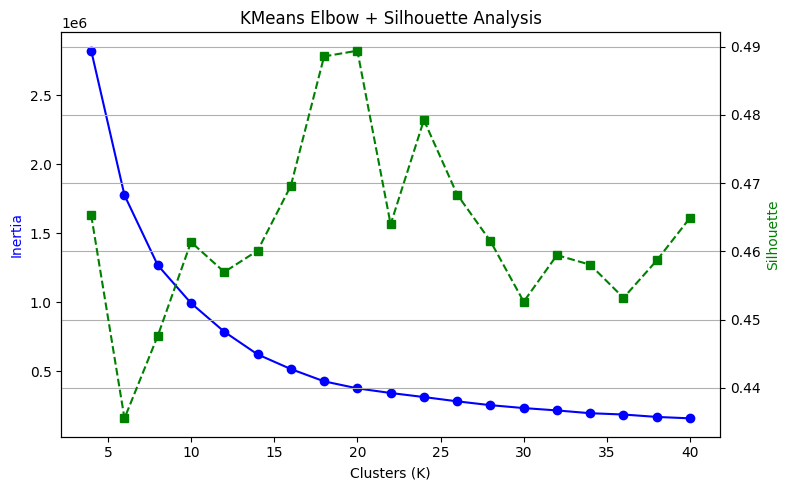

In [94]:
#  DISCOVERY PHASE 
K_RANGE = range(4, 41, 2)
if DISCOVERY:
    inertias, silhouettes = [], []
    print("\nRunning KMeans across cluster counts")
    for k in K_RANGE:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X_embed)
        inertia = km.inertia_
        inertias.append(inertia)

        if len(X_embed) > 10000:
            subset_idx = np.random.choice(len(X_embed), 10000, replace=False)
            sil = silhouette_score(X_embed[subset_idx], labels[subset_idx])
        else:
            sil = silhouette_score(X_embed, labels)

        silhouettes.append(sil)
        print(f"K={k:<3} | Inertia={inertia:,.0f} | Silhouette={sil:.4f}")

    #  Plot Elbow & Silhouette 
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax2 = ax1.twinx()
    ax1.plot(K_RANGE, inertias, "o-", color="blue", label="Inertia (Elbow)")
    ax2.plot(K_RANGE, silhouettes, "s--", color="green", label="Silhouette")
    ax1.set_xlabel("Clusters (K)")
    ax1.set_ylabel("Inertia", color="blue")
    ax2.set_ylabel("Silhouette", color="green")
    plt.title("KMeans Elbow + Silhouette Analysis")
    plt.grid(True)
    fig.tight_layout()
    plt.show()


In [106]:
BEST_K = 18  # change after inspecting plot

In [107]:
#  FINAL CLUSTERING 
print(f"\nUsing K={BEST_K} for final clustering")
kmeans = KMeans(n_clusters=BEST_K, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_embed)

#  Summarize 
cluster_summary = df.groupby("cluster")[available_features].mean().round(2)
print("\n Cluster Summary ")
print(cluster_summary)



Using K=18 for final clustering

 Cluster Summary 
         kills  deaths  assists    damage      cs  role  kp_rate  \
cluster                                                            
0         7.72    6.25     7.00  25457.99  197.61  3.58     0.00   
1        13.16   10.96    22.85  36066.34   63.54  3.38     0.01   
2         7.30    7.54     8.07  23700.80   90.09  3.83     0.00   
3         6.52    6.34     6.45  20224.39  176.50  2.16     0.00   
4         6.24    6.14     8.05  23358.23  158.74  3.06     0.00   
5        10.85   10.60    25.89  32479.99   44.97  3.54     0.01   
6         5.37    5.89     7.33  23725.38  178.79  2.87     0.00   
7         5.02    5.46     7.12  21294.63  178.40  1.48     0.00   
8         5.79    6.17     6.33  21111.38  184.62  3.79     0.00   
9        10.55    4.16     6.80  28090.20  195.95  2.51     0.01   
10        5.49    6.20     6.50  20209.85  174.38  1.56     0.00   
11        4.16    3.91     5.00  10483.59   54.29  3.39     0.00

In [118]:
import pickle

with open("../../models/kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

with open("../../models/umap_reducer.pkl", "wb") as f:
    pickle.dump(reducer, f)




Saved clustered dataset to ../../data/labeled_clusters.csv

 Visualizing Clusters 


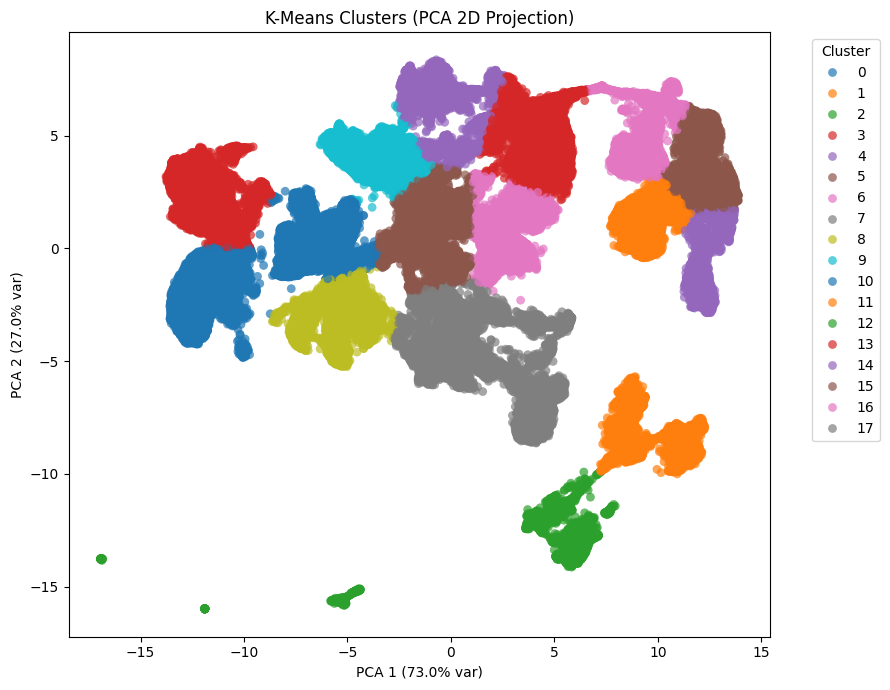

(3D PCA skipped: n_components=3 must be between 0 and min(n_samples, n_features)=2 with svd_solver='covariance_eigh')


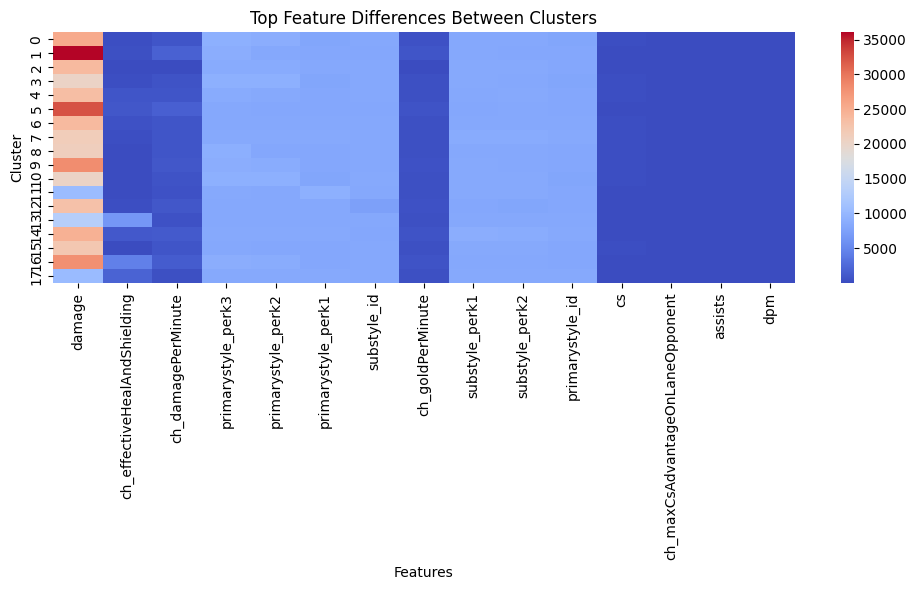

In [109]:
#  Save 
df.to_csv(SAVE_PATH, index=False)
print(f"\nSaved clustered dataset to {SAVE_PATH}")

#  Visualize 
visualize_kmeans(X_embed, df, kmeans, available_features)

In [110]:
import joblib

joblib.dump(kmeans, "../../models/kmeans_model.pkl")
joblib.dump(scaler, "../../models/scaler.pkl")

with open("../../models/features.txt", "w") as f:
    for feat in available_features:
        f.write(feat + "\n")

In [111]:
# Compute summary stats
summary = df.groupby("cluster")[[
    "kills", "deaths", "assists", "damage", "vision_score", "cs",
    "ch_kda", "ch_damagePerMinute", "ch_killParticipation", "ch_teamDamagePercentage",
    "ch_visionScorePerMinute", "ch_controlWardsPlaced",
    "ch_effectiveHealAndShielding", "attack", "defense", "magic"
]].mean()

# Normalize each column to 0–1 for easier comparison
summary_norm = (summary - summary.min()) / (summary.max() - summary.min())

In [112]:
def label_cluster(row):
    labels = []

    if row["damage"] > 0.7 or row["ch_damagePerMinute"] > 0.7:
        labels.append("Damage Dealer")
    if row["vision_score"] > 0.7 or row["ch_visionScorePerMinute"] > 0.7:
        labels.append("Vision Control")
    if row["defense"] > 0.7 and row["damage"] < 0.5:
        labels.append("Tanky")
    if row["attack"] > 0.7 and row["kills"] > 0.6:
        labels.append("Duelist")
    if row["magic"] > 0.6 and row["damage"] > 0.6:
        labels.append("Mage")
    if row["ch_effectiveHealAndShielding"] > 0.6:
        labels.append("Supportive")
    if row["ch_killParticipation"] > 0.65 and row["assists"] > 0.6:
        labels.append("Teamfighter")

    if not labels:
        labels.append("Balanced")

    return ", ".join(labels)

In [113]:
summary_norm["auto_label"] = summary_norm.apply(label_cluster, axis=1)

for tag in [c for c in df.columns if c.startswith("tag_")]:
    tag_means = df.groupby("cluster")[tag].mean()
    summary_norm[f"avg_{tag}"] = tag_means

In [114]:
def tag_modifier(row):
    if row.get("avg_tag_Mage", 0) > 0.5:
        return "Mage-heavy"
    if row.get("avg_tag_Tank", 0) > 0.5:
        return "Tank-heavy"
    if row.get("avg_tag_Assassin", 0) > 0.5:
        return "Assassin-heavy"
    if row.get("avg_tag_Support", 0) > 0.5:
        return "Support-heavy"
    if row.get("avg_tag_Fighter", 0) > 0.5:
        return "Fighter-heavy"
    if row.get("avg_tag_Marksman", 0) > 0.5:
        return "Marksman-heavy"
    return "Mixed"

In [115]:
summary_norm["tag_modifier"] = summary_norm.apply(tag_modifier, axis=1)
summary_norm["final_label"] = summary_norm["auto_label"] + " | " + summary_norm["tag_modifier"]

print(summary_norm[["auto_label", "tag_modifier", "final_label"]])
summary_norm.to_csv("../../data/cluster_labels.csv")
print("Saved labeled clusters to cluster_labels.csv")

                                     auto_label    tag_modifier  \
cluster                                                           
0                                      Balanced  Marksman-heavy   
1           Damage Dealer, Duelist, Teamfighter  Marksman-heavy   
2                                      Balanced           Mixed   
3                                      Balanced  Assassin-heavy   
4                                      Balanced      Mage-heavy   
5              Damage Dealer, Mage, Teamfighter      Mage-heavy   
6                                      Balanced      Mage-heavy   
7                                         Tanky      Tank-heavy   
8                                      Balanced      Mage-heavy   
9                                       Duelist           Mixed   
10                                        Tanky      Tank-heavy   
11                                     Balanced  Assassin-heavy   
12                                     Balanced           Mixe